In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import missingno as msno
from sklearn.impute import KNNImputer
# Autoreg, autocorrolationand time series tools...

from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic


plt.style.use('seaborn-whitegrid')

from termcolor import colored

This is a quick overview and analysis on the AQI(air quality index) of many cities in India. It's really interesting to examine different factors and see what has changed and how. We'll try to get an overall understanding of the coronavirus situation.


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/air-quality-data-in-india/city_day.csv
/kaggle/input/air-quality-data-in-india/stations.csv
/kaggle/input/air-quality-data-in-india/station_day.csv
/kaggle/input/air-quality-data-in-india/city_hour.csv
/kaggle/input/air-quality-data-in-india/station_hour.csv


In [3]:
city_day = pd.read_csv('/kaggle/input/air-quality-data-in-india/city_day.csv').sort_values(by = ['Date', 'City'])

In [4]:
print(list(city_day.columns))

['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']


In [5]:
city_day.head(2)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.0,NaN,NaN
4294,Bengaluru,2015-01-01,NaN,NaN,3.26,17.33,10.88,20.36,0.33,3.54,10.73,0.56,4.64,NaN,NaN,NaN


In [6]:
city_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.8+ MB


In [7]:
city_day.Date = city_day.Date.apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
city_day = city_day.sort_values(by = 'Date')

In [8]:
print('Date starts from {}, and ends in {}'.format(city_day.Date.min().strftime('%Y-%m-%d'), city_day.Date.max().strftime('%Y-%m-%d')))

Date starts from 2015-01-01, and ends in 2020-07-01


Let's see which columns/type of pollution are generally making the AQI go higher.

In [9]:
city_day.corr().AQI.sort_values(ascending = False)

AQI        1.000000
PM10       0.803313
CO         0.683346
PM2.5      0.659181
NO2        0.537071
SO2        0.490586
NOx        0.486450
NO         0.452191
Toluene    0.279992
NH3        0.252019
O3         0.198991
Xylene     0.165532
Benzene    0.044407
Name: AQI, dtype: float64

Let's generate some features:

In [10]:
# adding all the features with corr less than 0.4

city_day['B_X_O3_NH3'] = city_day['Benzene'] +\
city_day['Xylene'] + city_day['O3'] + city_day['NH3']

city_day['ParticulateMatters'] = city_day['PM2.5'] + city_day['PM10']

corr_with_AQI = city_day.corr().AQI.sort_values(ascending = False)


corr_with_AQI
# from here we can see: we can impute values with linear
# interpolation for the ones that have high value of corr


AQI                   1.000000
ParticulateMatters    0.823098
PM10                  0.803313
CO                    0.683346
PM2.5                 0.659181
B_X_O3_NH3            0.605700
NO2                   0.537071
SO2                   0.490586
NOx                   0.486450
NO                    0.452191
Toluene               0.279992
NH3                   0.252019
O3                    0.198991
Xylene                0.165532
Benzene               0.044407
Name: AQI, dtype: float64

In [11]:
# how much is the average amount of pollution in each city stations
most_polluted = city_day[['City', 'AQI', 'PM10', 'CO']].groupby(['City']).mean().sort_values(by = 'AQI', ascending = False)
most_polluted

,AQI,PM10,CO
City,,,
Ahmedabad,452.122939,114.584029,22.193407
Delhi,259.487744,232.809229,1.976053
Patna,240.782042,126.747958,1.533591
Gurugram,225.123882,191.504432,1.257516
Lucknow,217.973059,NaN,2.130328
Talcher,172.886819,165.772708,1.847722
Jorapokhar,159.251621,149.657942,0.663049
Brajrajnagar,150.280505,124.217373,1.798274
Kolkata,140.566313,115.629499,0.799251


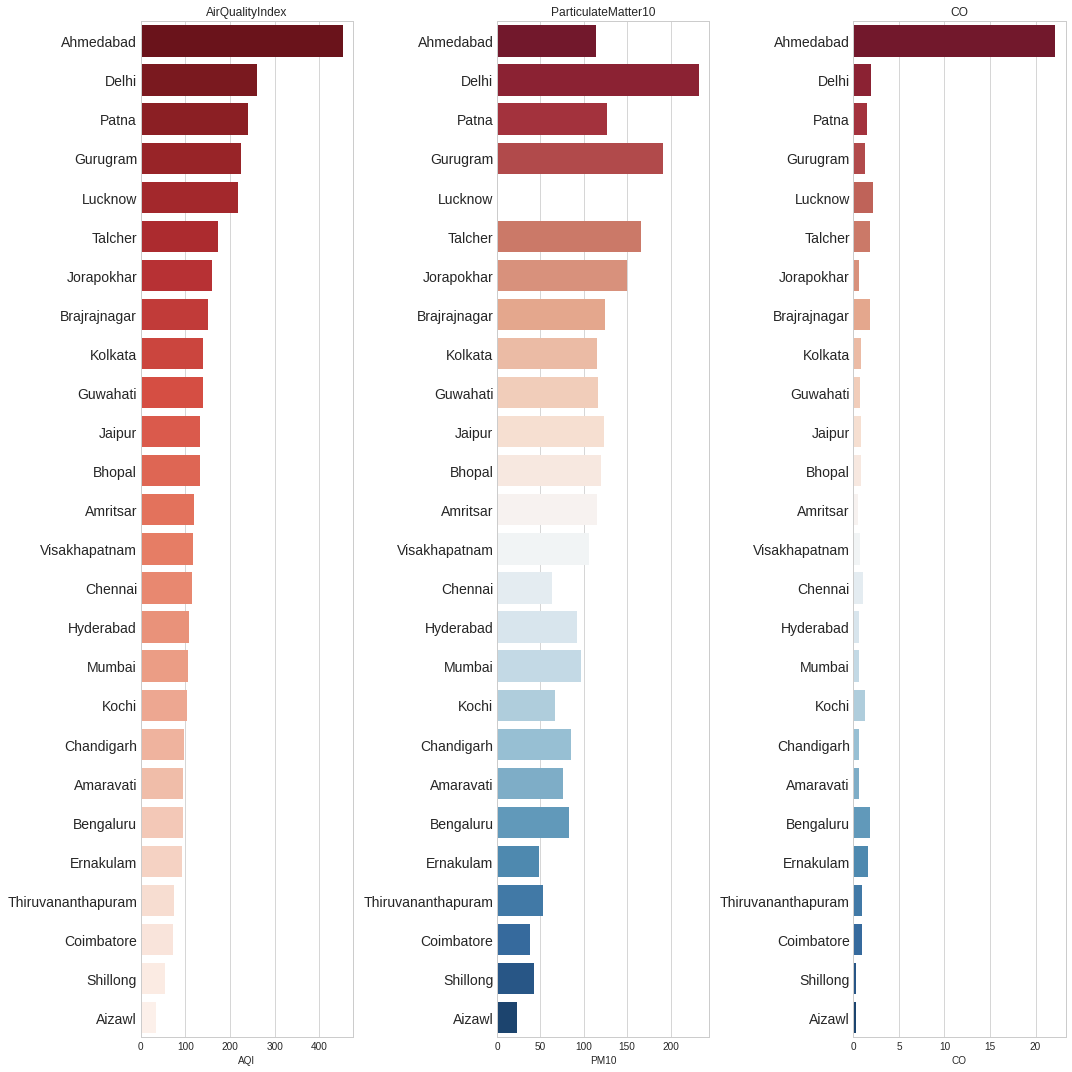

In [12]:
plt.style.use('seaborn-whitegrid')
f, ax_ = plt.subplots(1, 3, figsize = (15,15))

bar1 = sns.barplot(x = most_polluted.AQI,
                   y = most_polluted.index,
                   palette = 'Reds_r',
                   ax = ax_[0]);

bar1 = sns.barplot(x = most_polluted.PM10,
                   y = most_polluted.index,
                   palette = 'RdBu',
                   ax = ax_[1]);

bar1 = sns.barplot(x = most_polluted.CO,
                   y = most_polluted.index,
                   palette = 'RdBu',
                   ax = ax_[2]);

titles = ['AirQualityIndex', 'ParticulateMatter10', 'CO']
for i in range(3) :
    ax_[i].set_ylabel('')   
    ax_[i].set_yticklabels(labels = ax_[i].get_yticklabels(),fontsize = 14);
    ax_[i].set_title(titles[i])
    f.tight_layout()


Wait a minute... how is Ahmadabad more polluted than Dehli, but doesn't have a high amount of particulate matter?(PM10)
well it may be because of the stations, maybe they could not measure this feature from the early days that this survay started.
Let's findout when were the first times that each measurement has been being conducted for each city so we won't be misunderstanding anything.

In [13]:
most_polluted = city_day[['City', 'AQI', 'PM10', 'CO']].groupby(['City']).mean().sort_values(by = 'AQI', ascending = False)

cities = most_polluted.index
params = most_polluted.columns

def first_date(city, parameter):
    df = city_day[(city_day.City == city)]
    df = df[df[parameter].notnull()]
    if len(df) != 0:
        return df.iloc[0].Date.strftime('%Y-%m-%d')
    else: return('no_measurement')
        
        
for city in cities:
    #print(colored('city: ', 'green'), city)
    for param in params:
      #  print('param: ', param)
        most_polluted.loc[city, str(param) + '_date'] = first_date(city, param)
        
most_polluted

,AQI,PM10,CO,AQI_date,PM10_date,CO_date
City,,,,,,
Ahmedabad,452.122939,114.584029,22.193407,2015-01-29,2019-05-14,2015-01-01
Delhi,259.487744,232.809229,1.976053,2015-01-01,2015-01-01,2015-01-01
Patna,240.782042,126.747958,1.533591,2015-10-03,2019-12-24,2015-06-01
Gurugram,225.123882,191.504432,1.257516,2016-01-23,2017-12-31,2015-11-27
Lucknow,217.973059,NaN,2.130328,2015-03-21,no_measurement,2015-01-01
Talcher,172.886819,165.772708,1.847722,2018-02-08,2018-02-07,2017-12-20
Jorapokhar,159.251621,149.657942,0.663049,2017-04-21,2017-04-20,2017-04-20
Brajrajnagar,150.280505,124.217373,1.798274,2017-12-08,2017-12-07,2017-12-07
Kolkata,140.566313,115.629499,0.799251,2018-04-11,2018-04-10,2018-04-10


Oh yes. That's right, they didn't even measure PM10 till June 2015. 
But now let's look at the sum of all the pollution measurements and compare them to each other.

In [14]:
# Sum of pollution
import plotly.express as px

df = city_day.drop(columns = ['Date', 'AQI_Bucket', 'AQI']).groupby('City').sum().reset_index()
fig = px.treemap(pd.melt(df, id_vars = 'City'), path=['City','variable'],
                 values=pd.melt(df, id_vars = 'City')['value'],
                 title = 'Cities and the proportion of pollution in each')
fig.show()

Let's see if there is any seasonality(visually and not with any stat tool, but we'll see more on this later on this kernel)

In [15]:
city_day['Year_Month'] = city_day.Date.apply(lambda x : x.strftime('%Y-%m'))

In [16]:
df = city_day.groupby(['Year_Month']).sum().reset_index()

# let's only see those that are important to the AQI
# otherwise we will have a messy plot

metrices = corr_with_AQI[corr_with_AQI>0.5].index

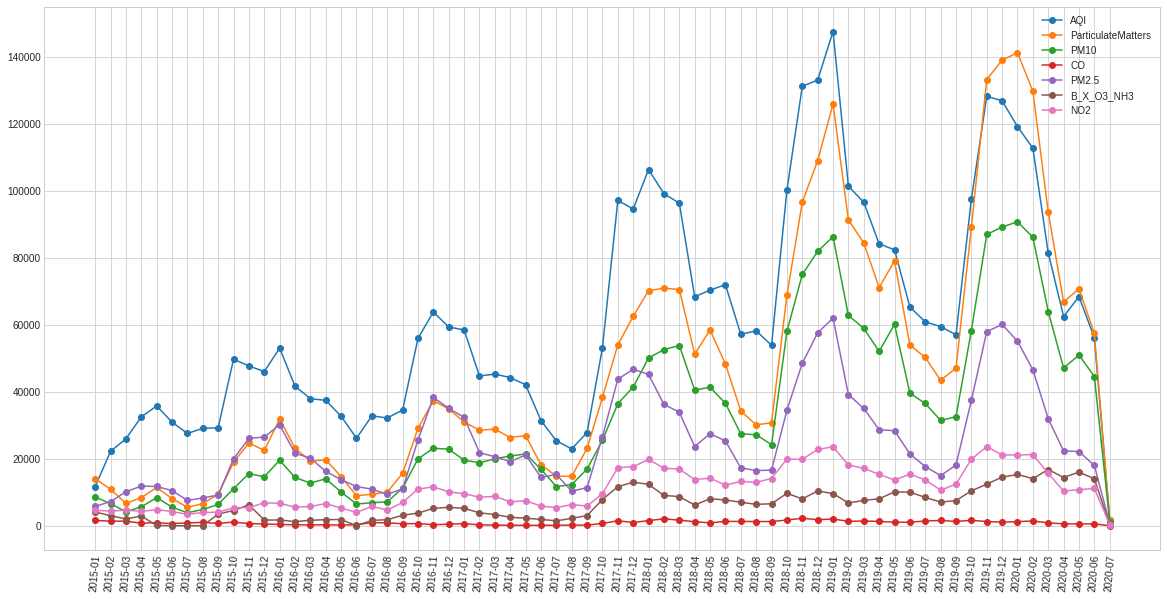

In [17]:
plt.style.use('seaborn-whitegrid');
fig, ax_ = plt.subplots(figsize=(20,10));

df = city_day.groupby(['Year_Month']).sum().reset_index()

for col in metrices:
    x = df['Year_Month']
    y = df[col]
    
    ax_.plot_date(x ,y ,label=col, linestyle="-");
    
ax_.set_xticklabels(df['Year_Month'], rotation=85);
ax_.legend();

For most metrices we can see that there is an obvious seasonality with an increasing trend. We will go deeper into this seasonality by plotting the sum of pollution in all years with respect to the months.

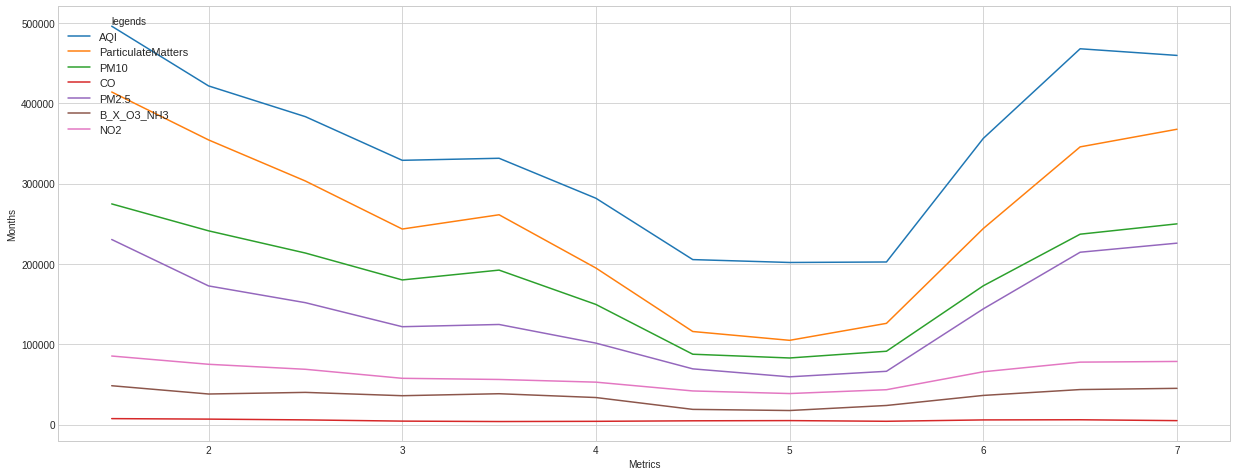

In [18]:
city_day['Month'] = city_day.Date.dt.month
city_day['Year'] = city_day.Date.dt.year

index = 'Month'
df = city_day.groupby([index]).sum().reset_index()

plt.style.use('seaborn-whitegrid');
fig, ax_ = plt.subplots(figsize=(21,8));


for i, col in enumerate(metrices):
    x = df[index]
    y = df[col]
    plot = sns.lineplot(x ,y );
    

plot.set_xticklabels(df[index], );
ax_.set(xlabel='Metrics', ylabel='Months');
leg = plot.legend(title='legends', loc='upper left', labels=metrices, fontsize = 11);


The pollution level drops as we get closer to summer and again escelates in colder seasons. This is deemed to be related to the monsoon(the wind that carries heavy rains to southern Asia.)

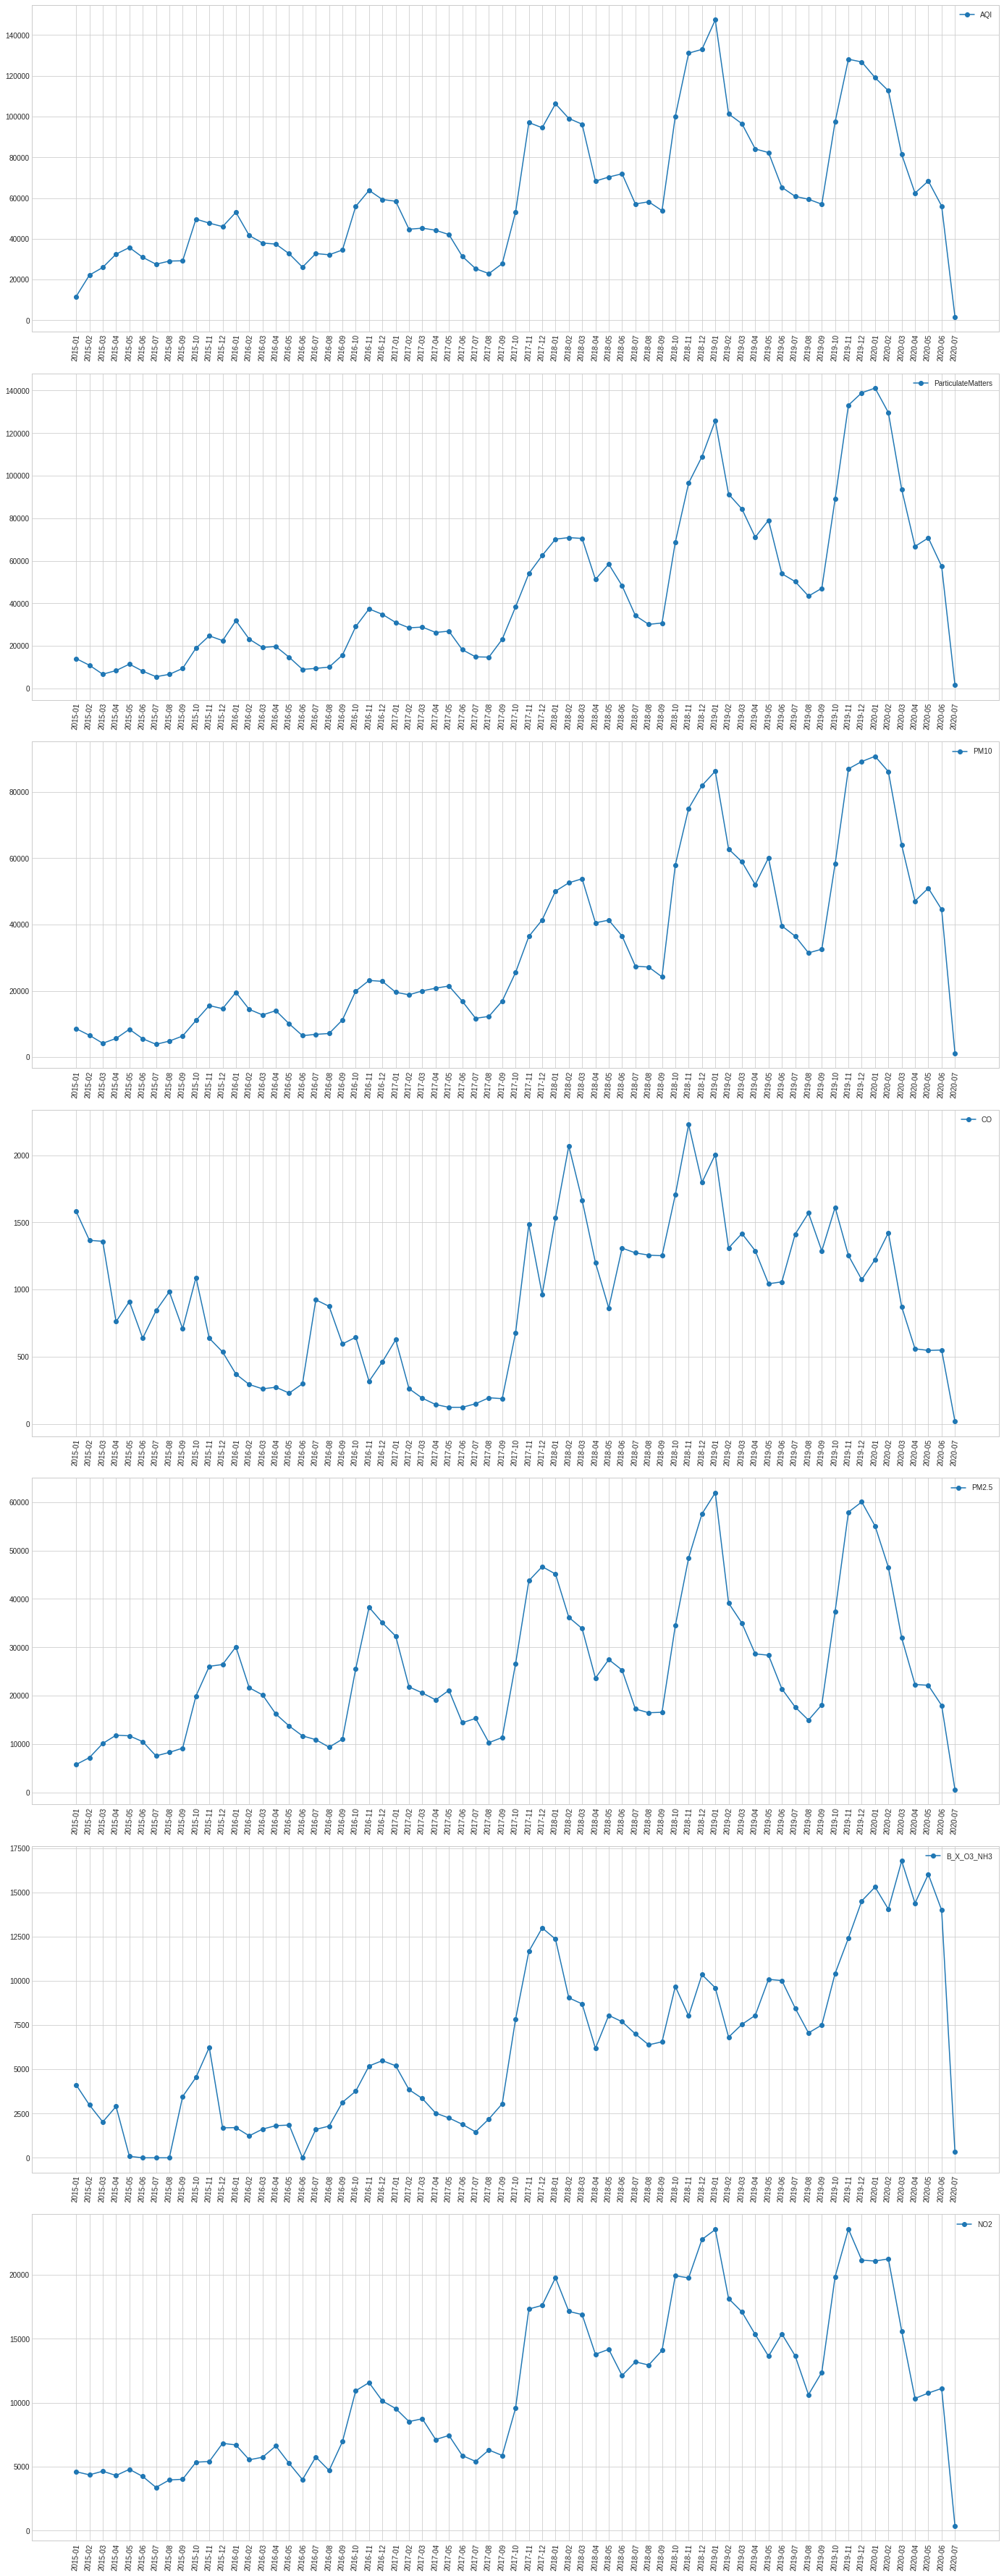

In [19]:
df = city_day.groupby(['Year_Month']).sum().reset_index()

plt.style.use('seaborn-whitegrid')
fig, ax_ = plt.subplots(len(metrices), 1, figsize=(20,50))

fig.tight_layout(pad=4)
for i, col in enumerate(metrices):
    
    x = df['Year_Month']
    y = df[col]
    ax_[i].plot_date(x ,y ,label=col, linestyle="-")
    ax_[i].set_xticklabels(df['Year_Month'], rotation=85);
    ax_[i].legend();

## Null values?

In [20]:
def tell_me_null(df):
    num_null = df.isnull().sum().sort_values(ascending = False)
    percentage_null = round(df.isnull().sum().sort_values(ascending = False)/len(df) * 100, 1)
    return pd.DataFrame(np.c_[num_null, percentage_null], index = num_null.index,  columns = ['# of Null', 'Percentage'])

In [21]:
tell_me_null(city_day)

,# of Null,Percentage
B_X_O3_NH3,22788.0,77.2
Xylene,18109.0,61.3
ParticulateMatters,11899.0,40.3
PM10,11140.0,37.7
NH3,10328.0,35.0
Toluene,8041.0,27.2
Benzene,5623.0,19.0
AQI_Bucket,4681.0,15.9
AQI,4681.0,15.9
PM2.5,4598.0,15.6


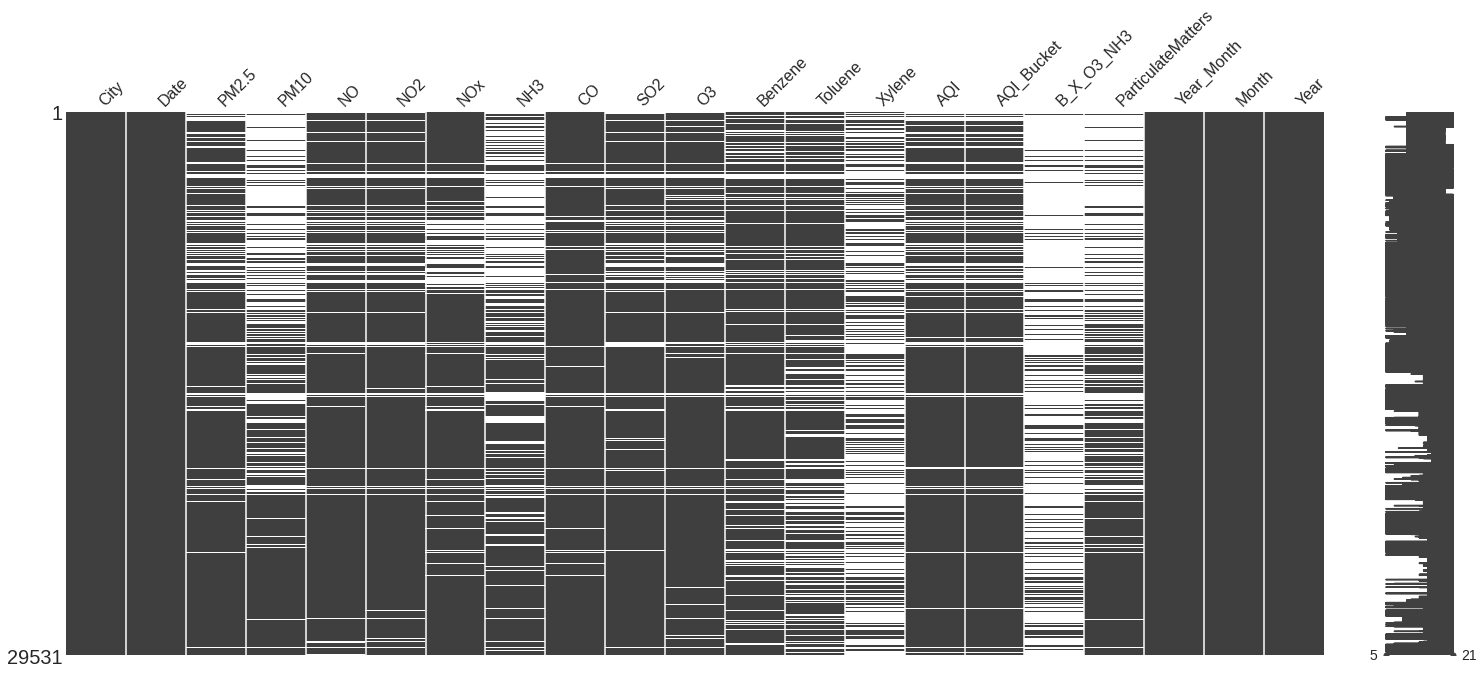

In [22]:
plt.style.use('seaborn-whitegrid')
msno.matrix(city_day, );

In [23]:
# we'll work on one city and fill it's values and go deeper on that one for simplicity

delhi = city_day[(city_day.AQI.notnull()) & (city_day.City == 'Delhi')]

In [24]:
delhi.corr().AQI.sort_values(ascending = False)

AQI                   1.000000
ParticulateMatters    0.915609
PM10                  0.884864
PM2.5                 0.882132
Benzene               0.669889
NO2                   0.665756
NO                    0.641858
B_X_O3_NH3            0.627041
NOx                   0.555848
NH3                   0.519026
SO2                   0.414702
O3                    0.330224
CO                    0.279836
Toluene               0.278970
Xylene                0.231137
Month                 0.055912
Year                 -0.284811
Name: AQI, dtype: float64

In [25]:
tell_me_null(delhi)

,# of Null,Percentage
B_X_O3_NH3,772.0,38.6
Xylene,771.0,38.6
SO2,102.0,5.1
O3,76.0,3.8
ParticulateMatters,69.0,3.5
PM10,69.0,3.5
NH3,8.0,0.4
PM2.5,1.0,0.1
NO,1.0,0.1
NO2,1.0,0.1


In [26]:
corr = delhi.corr().AQI.sort_values(ascending = False)
related = list(corr[corr>0.6].index)
print(related)
inter = delhi.loc[:, related].interpolate(method = 'linear');
delhi.loc[:, related] = inter

['AQI', 'ParticulateMatters', 'PM10', 'PM2.5', 'Benzene', 'NO2', 'NO', 'B_X_O3_NH3']


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
delhi.columns

Index(['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket', 'B_X_O3_NH3',
       'ParticulateMatters', 'Year_Month', 'Month', 'Year'],
      dtype='object')

In [28]:
knn_imputer = KNNImputer(n_neighbors = 3)

imputing_cols = [ 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2',
       'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'B_X_O3_NH3',
       'ParticulateMatters', 'Month', 'Year']
# we eliminated city, date, Year_Month and AQI_Bucket because 
# they either were unique or had numerical substitude in other fields(AQI_bucket)

knn_imputer.fit(delhi[imputing_cols])

imputed = knn_imputer.transform(delhi[imputing_cols])

delhi.loc[:, imputing_cols] = imputed



/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
tell_me_null(delhi)

,# of Null,Percentage
Year,0.0,0.0
SO2,0.0,0.0
Date,0.0,0.0
PM2.5,0.0,0.0
PM10,0.0,0.0
NO,0.0,0.0
NO2,0.0,0.0
NOx,0.0,0.0
NH3,0.0,0.0
CO,0.0,0.0


In [30]:
# we want to see what would have happened if there was no quarentine
# so we start our analysis using the data before 2020
# but first let's see how many records are in 2020

x_pred_after = delhi[delhi.Date > '2020-01-01']
delhi_b = delhi[delhi.Date < '2020-01-01']

print("the proportion of data recorded in 2020: {:.2f}".format (len(x_pred_after)/len(delhi)))

the proportion of data recorded in 2020: 0.09


In [31]:
delhi_monthly = delhi_b.groupby('Year_Month').mean().reset_index().sort_values(by ='Year_Month')
delhi_daily = delhi_b.groupby('Date').mean().reset_index().sort_values(by ='Date')

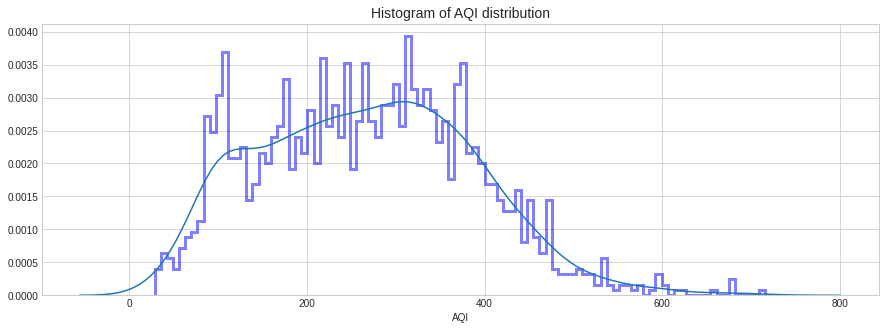

In [32]:
plt.figure(figsize = (15,5))
plot = sns.distplot(delhi_daily.AQI,bins = 100, hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 0.5, "color": "blue"});
plot.set_title('Histogram of AQI distribution', fontsize = 14); 

The shape that we got isn't a neat and clean bell shape so we can suspect that there is a seasonality that stops the air quality indices to be in a specified range.
Let's see if it is stationary or non-stationary.
(Stationary: has a specific mean and variance that don't change over time,
non-stationary: has a changing mean and variance.)
We do this test to better understand the dataset.

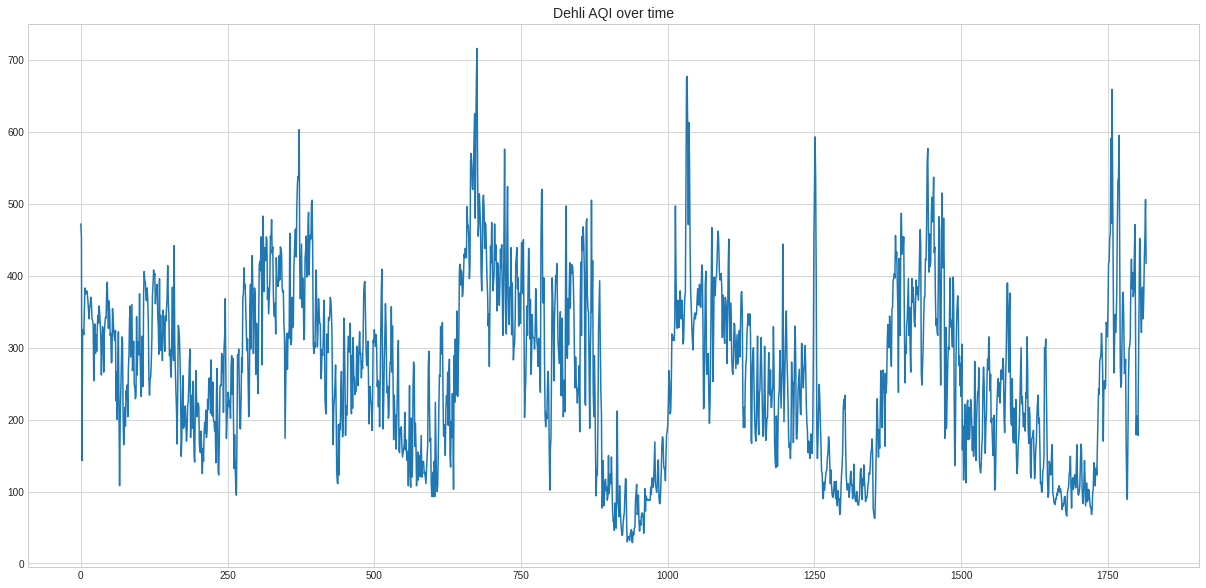

In [33]:
# a quick look on how the aqi has changed overtime
plt.style.use('seaborn-whitegrid')
delhi_daily.AQI.plot( figsize = (21,10));
plt.title('Dehli AQI over time', fontsize = 14);

In [34]:

# the null hypothesis is that it is non_stationary
# function for adfuller:

def test_adfuller(df, field):
    results = adfuller(df[field],)
    print('This is the adfuller statistic:%.3f'%(results[0]))
    print('This is the p_value: %.5f' % (results[1])) 
    print('The Critical Values for each probability:\n')
    for key, value in results[4].items():
        print('%s: %.3f'%(key, value))
    if (results[0]) < list(results[4].values())[0] :
        print('This data is a cool', colored( 'Stationary dataset!', 'green'))
    else:
        print('This is a non_cool',colored( 'non_stationary dataset!', 'yellow'))

In [35]:
test_adfuller(delhi_daily, 'AQI')

This is the adfuller statistic:-3.353
This is the p_value: 0.01265
The Critical Values for each probability:

1%: -3.434
5%: -2.863
10%: -2.568
This is a non_cool non_stationary dataset!


Because the data is non-stationary, we can't use the actuall data to predict with methods like autoregressive model. But we can use very simple methods like averaging to do one-step prediction and predict each day based on the several previous days. In this case the data has to have auto correlation(it has to corrolate with itself. So we can predict the next day based on previous days.)

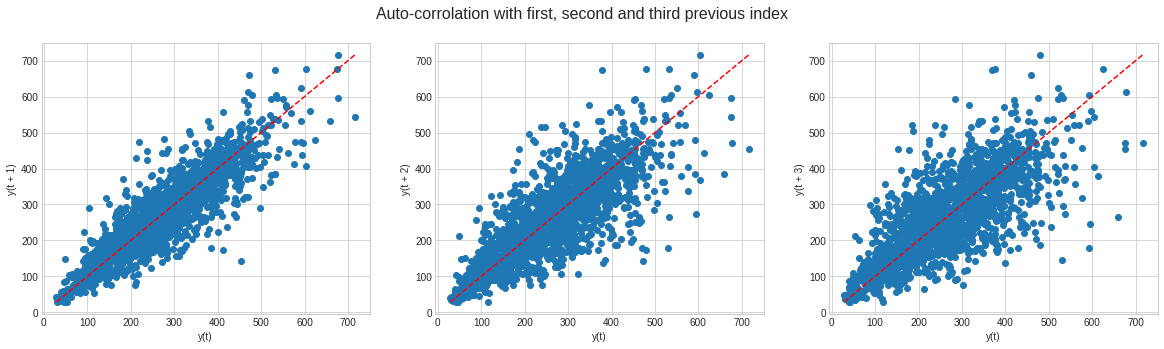

In [36]:
fig, ax_ = plt.subplots(1, 3, figsize = (20, 5))
aqi_serie = delhi_daily.AQI
for i in range(3):
    
    lag_plot((aqi_serie), lag = i+1, ax = ax_[i]);
    ax_[i].plot([min(aqi_serie), max(aqi_serie)], [min(aqi_serie), max(aqi_serie)],'--', color = 'red' )

fig.suptitle('Auto-corrolation with first, second and third previous index', fontsize = 16);

There is a relatively good auto-correlation when we compare each day's index with the previous day's index. so There is a good chance to predict the quality of air well, if we have the previous day's data.
# One step prediction
## Here I'll generate a base method to predict index of each day just as the previous day


In [37]:
shifted = pd.concat([delhi_daily.Date, delhi_daily.AQI, delhi_daily.AQI.shift(1)], axis = 1)
shifted.columns = ['Date', 'actual', 'pred']
shifted.head(2)

,Date,actual,pred
0,2015-01-01,472.0,NaN
1,2015-01-02,454.0,472.0


In [38]:
shifted.corr()
# There is about 90 precent correlation between each day's index and the previous day's index.
# So it can be a good method to predict each day based on previous.

,actual,pred
actual,1.00000,0.89721
pred,0.89721,1.00000


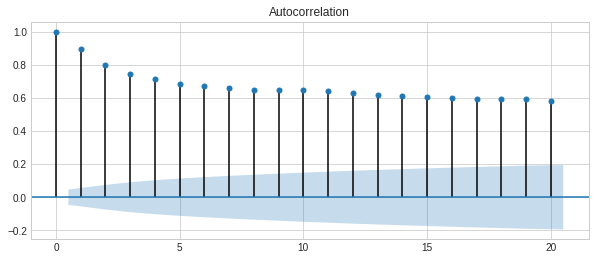

In [39]:
# here is the auto-correlation plot.
# It shows us how much we can depend on each of the previous indices(separately.)
# each line is representing the correlation of Y(t-n) to Y(t)
# and the more it is in the blue area, the more certain we are that it actually has this correlation most of the time

N = 20
fig, ax_ = plt.subplots( figsize = (10,4))
plot_acf(delhi_daily.AQI, lags = N, alpha = 0.05, use_vlines = True, ax = ax_ )
fig.show()

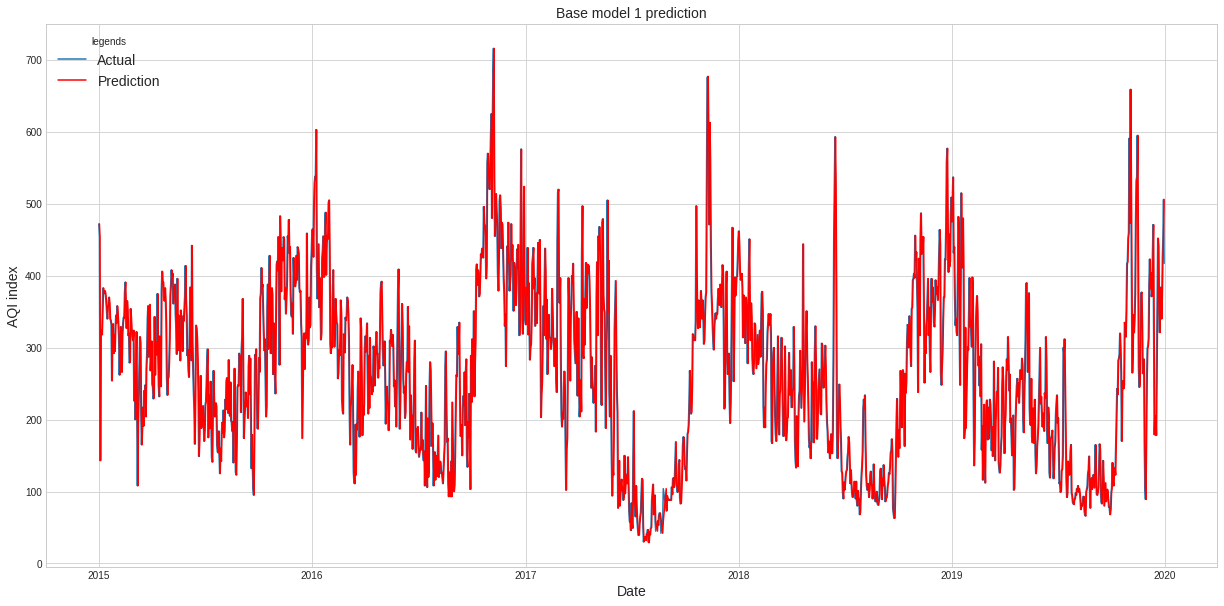

In [40]:
plt.figure(figsize = (21,10))

sns.lineplot(shifted.Date, shifted.actual, sort = False)
plot = sns.lineplot(shifted.Date, shifted.pred, color = 'red')

plot.legend(title='legends', loc='upper left',
           labels=['Actual', 'Prediction'], fontsize = 14)


plot.set_ylabel('AQI index', fontsize = 14);
plot.set_xlabel('Date', fontsize = 14);
plot.set_title('Base model 1 prediction', fontsize = 14);


In [41]:
base_error_1 = mean_squared_error(shifted[1:].actual, shifted[1:].pred)
print('The error of our simple and basic model is: {:.2f}'.format(base_error_1))

The error of our simple and basic model is: 2922.68


## Here we'll generate another simple one-step model that predicts each future value based on average of N previous values

In [42]:
N = 3
def average_of_N_previous_records(N, df):
    df[ 'average_of_N_previous_records'] = 0
    for i in range(N, len(df)):
        #print(i)
        for n in range(1, N+1):

            df.loc[i, 'average_of_N_previous_records'] += df.loc[i-n, 'AQI']
    df.loc[:, 'average_of_N_previous_records'] /=3
    df.loc[:N-1, 'average_of_N_previous_records'] = np.nan
    
average_of_N_previous_records(N, delhi_daily)

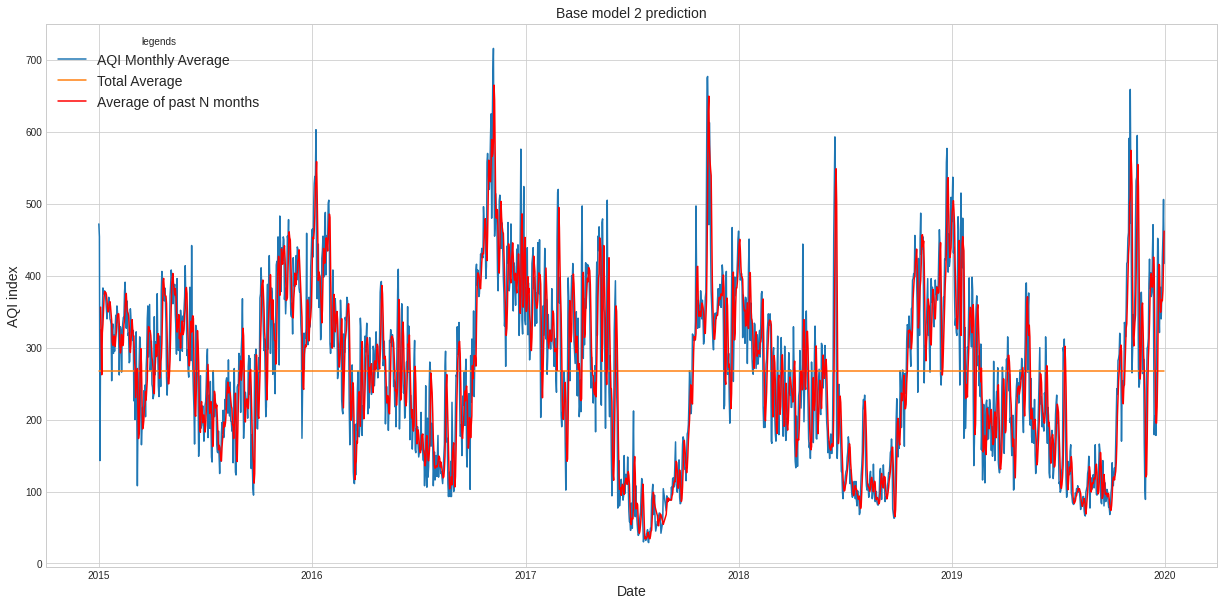

In [43]:
# Plotting the result
mean = delhi_daily.AQI.mean()
first_date = min(delhi_b.Date)
last_date = max(delhi_b.Date)


N = 3
plt.figure(figsize = (21,10))
sns.lineplot(delhi_daily.Date, delhi_daily.AQI, sort = False)
sns.lineplot([first_date, last_date], [mean,mean])

plot = sns.lineplot(delhi_daily.Date,
             delhi_daily.average_of_N_previous_records, 
              color = 'red')

plot.legend(title='legends', loc='upper left',
           labels=['AQI Monthly Average', 'Total Average', 'Average of past N months'], fontsize = 14)


plot.set_ylabel('AQI index', fontsize = 14);
plot.set_xlabel('Date', fontsize = 14);
plot.set_title('Base model 2 prediction', fontsize = 14);

In [44]:
base_error_2 = mean_squared_error(delhi_daily.AQI[N:], delhi_daily.average_of_N_previous_records[N:])
print('The error of averaging {} previous records model is: {:.2f}'.format(N, base_error_2))
# Though the difference is not that much,
# because the error gets bigger we should say averaging doesn't seem to be a great method for one-step predicton


The error of averaging 3 previous records model is: 3913.13


## Here we'll use auto regression model for predicting
An autoreg model combines different previous records. It will not work properly or be able to predict well when there is a volatile mean and variance and set the best coefficients for each Y(t).

So because our data is non-stationary, we either have to use methods like subtracting (Y(t) - Y(t-1)) or some features of Autoreg package to delete the trend and seasonality of our dataset.


In [45]:
# let's first predict the last 7 records by using the last 20 previous records of each

train, test = delhi_daily.AQI[:-7], delhi_daily.AQI[-7:]
model = AutoReg(train, lags = N)
fitted_model = model.fit()

y_pred_autoreg = fitted_model.predict(start = list(test.index)[0],
                                      end = list(test.index)[-1],
                                      dynamic = False)
pd.DataFrame(np.c_[test, y_pred_autoreg], columns= ['actual', 'pred'])

,actual,pred
0,384.0,372.427489
1,340.0,353.787190
2,372.0,346.997457
3,425.0,343.519059
4,455.0,338.261444
5,506.0,332.855328
6,417.0,328.222837


In [46]:
# to make sure what is the best N for our autoregression equation,
# let's try out different numbers and take the one with lowest error

N = 100
train, test = delhi_daily.AQI[:-20], delhi_daily.AQI[-20:]

model = AutoReg(train, lags = 1, seasonal=True, trend = 'c', period = 365)
fitted_model = model.fit()
y_pred_autoreg = fitted_model.predict(start = list(test.index)[0],
                                    end = list(test.index)[-1],
                                    dynamic = False)
error = mean_squared_error(test, y_pred_autoreg)
best_n = 0
trend_ = 'c'
seasonal_ = True
# we know if there is any seasonality it will be 365 days period so we won't use a for loop for that.
for n in range(1, N):
    
    for trend in ['n', 'c', 't', 'ct']:
        
        for seasonal in [True, False]:
            model = AutoReg(train, lags = n, seasonal=seasonal, trend = trend, period = 365)
            fitted_model = model.fit()
            y_pred_autoreg = fitted_model.predict(start = list(test.index)[0],
                                                  end = list(test.index)[-1],
                                                  dynamic = False)

            mse = mean_squared_error(test, y_pred_autoreg)

            if error > mse:
                error = mse
                best_n = n
                trend_ = trend
                seasonal_ = seasonal

In [47]:
print('The best number of previous records to use for prediction is: ', colored(best_n, 'yellow'))
print('The Trend parameter is: ', colored(trend_, 'yellow'))
print('The seasonal parameter is: ', colored(seasonal_, 'green'))

The best number of previous records to use for prediction is:  17
The Trend parameter is:  n
The seasonal parameter is:  True


In [48]:
train = delhi_daily.AQI

model = AutoReg(train, lags = best_n, seasonal = seasonal_, period = 365, trend = trend_)
fitted_model = model.fit()
y_pred_autoreg = fitted_model.predict(start = list(train.index)[0],
                                      end = list(train.index)[-1],
                                      dynamic = False)
delhi_daily['Autocorr'] = y_pred_autoreg

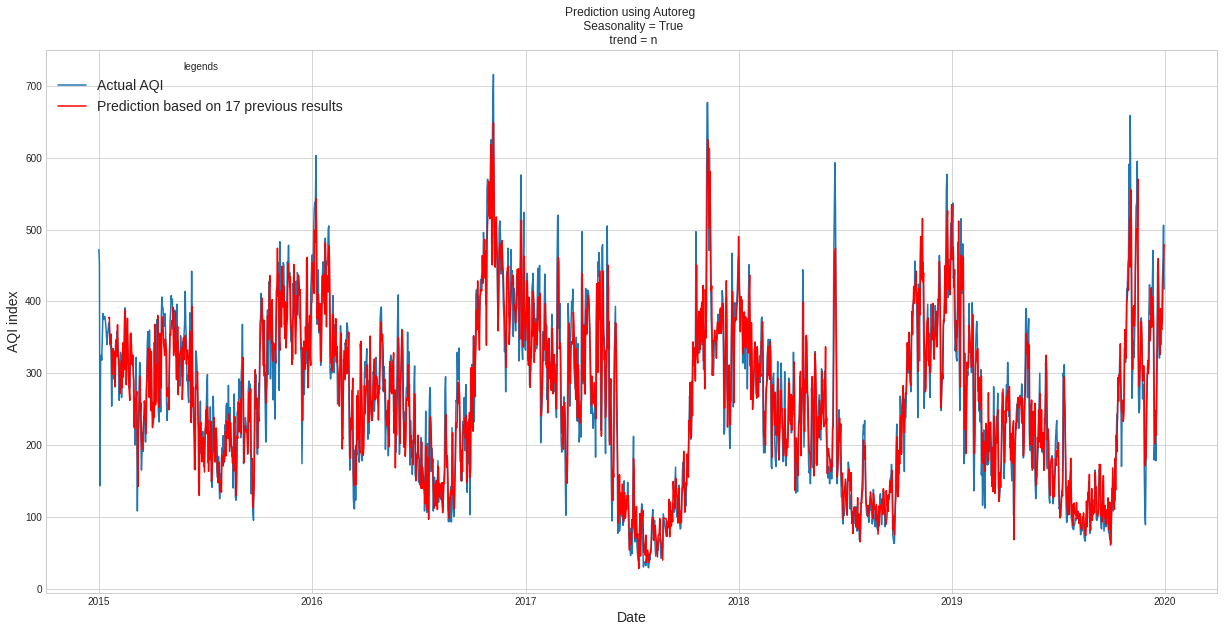

In [49]:
plt.figure(figsize = (21,10))

sns.lineplot(delhi_daily.Date, delhi_daily.AQI, sort = False)

plot = sns.lineplot(delhi_daily.Date,
             delhi_daily.Autocorr, 
              color = 'red')

plot.legend(title='legends', loc='upper left',
           labels=['Actual AQI', 'Prediction based on '+str(best_n)+' previous results'], fontsize = 14)


plot.set_ylabel('AQI index', fontsize = 14);
plot.set_xlabel('Date', fontsize = 14);
plot.set_title('Prediction using Autoreg \n Seasonality = '+str(seasonal_)+'\n trend = '+str(trend_));


we'll again measure the mean squared error, but bare in mind that this is not an ideal way to assert the quality of base models because each of the models predict a specific number of records. For a better assersion we shall measure the mean squared error of all the records starting from a specific Nth record.
I this case N would be 30.

In [50]:
autoreg_error_1 = mean_squared_error(delhi_daily.Autocorr[best_n:], delhi_daily.AQI[best_n:])
print('The error of the autoregression model is: {:.2f}'.format(autoreg_error_1))

The error of the autoregression model is: 1901.47


Thank you for baring with me and going through this dataset. I hope I could help you. 
I have to thank [this](https://www.kaggle.com/parulpandey/a-guide-to-handling-missing-values-in-python) kernel's writer too, for having amazing insight for me in writing this kernel! 
Please feel free to ask me your questions. Constuctive critisism is also welcome!
Good luck!